In [1]:
import torchvision
from torchvision import datasets
from torchvision.transforms import transforms

import torch
from torch import nn
from torch.nn import functional as F
from torch.distributions import Bernoulli
from torchmetrics import Accuracy

import numpy as np

import math

import sys
sys.path.append("/home/betairya/RP_ML/Active-learning-features/Uncertainty-expr")
print(sys.path)

from data_uncertainty import MNIST_UncertaintyDM, CIFAR10_UncertaintyDM

['/home/betairya/RP_ML/Active-learning-features/ToyExperiments/Dropout', '/home/betairya/anaconda3/lib/python310.zip', '/home/betairya/anaconda3/lib/python3.10', '/home/betairya/anaconda3/lib/python3.10/lib-dynload', '', '/home/betairya/anaconda3/lib/python3.10/site-packages', '/home/betairya/anaconda3/lib/python3.10/site-packages/PyQt5_sip-12.11.0-py3.10-linux-x86_64.egg', '/home/betairya/anaconda3/lib/python3.10/site-packages/mpmath-1.2.1-py3.10.egg', '/home/betairya/RP_ML/Active-learning-features/Uncertainty-expr']


In [2]:
n_labeled = 16384

# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.5, ), (0.5, ))])
# dataset_train = datasets.MNIST(root = "../../data", transform = transform, train = True, download = True)
# dataset_train = torch.utils.data.Subset(dataset_train, np.random.choice(len(dataset_train), size = (n_labeled,)))
# dataset_test = datasets.MNIST(root = "../../data", transform = transform, train = False, download = True)

# input_ch = 1
# image_size = 28
# dataset_name = "MNIST"

# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

# dataset_train = datasets.CIFAR10(root = "../../data", transform = transform, train = True, download = True)
# dataset_train = torch.utils.data.Subset(dataset_train, np.random.choice(len(dataset_train), size = (n_labeled,)))
# dataset_test = datasets.CIFAR10(root = "../../data", transform = transform, train = False, download = True)

# input_ch = 3
# image_size = 32
# dataset_name = "CIFAR10"

# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.5, ), (0.5, ))])

# dataset_train = datasets.SVHN(root = "../../data", transform = transform, split = 'train', download = True)
# dataset_train = torch.utils.data.Subset(dataset_train, np.random.choice(len(dataset_train), size = (n_labeled,)))
# dataset_test = datasets.SVHN(root = "../../data", transform = transform, split = 'test', download = True)
# dataset_train = torch.utils.data.Subset(dataset_test, np.random.choice(len(dataset_train), size = (4096,)))

# input_ch = 3
# image_size = 32
# dataset_name = "SVHN"

main_dm = CIFAR10_UncertaintyDM(data_dir = "./data", batch_size = 128, num_workers = 0, do_partial_train = False, do_contamination = True, blur_sigma = 2.0, noise_std = 0.0)
main_dm.setup()
dataset_train = main_dm.train_dataloader().dataset
dataset_test = main_dm.val_dataloader().dataset

input_ch = 3
image_size = 32
dataset_name = "CIFAR10"

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [3]:
class Recorder(nn.Module):
    
    def __init__(self, wrappedLayer):
        super().__init__()
        self.wrappedLayer = wrappedLayer
        
        self.isRecord = False
        self.isReplay = False
        
    def switchToRecord(self):
        self.isReplay = False
        self.isRecord = True
        
    def switchToReplay(self):
        self.isReplay = True
        self.isRecord = False
        
    def switchToIdentity(self):
        self.isReplay = False
        self.isRecord = False
        
    def forward(self, x):
        
        if self.isRecord:
            z = self.wrappedLayer(x)
            self.buffer = z / x
            self.buffer[self.buffer != self.buffer] = 0 # Set NaN (x = 0) values to 0 (assume actfunc = 0 at x = 0)
            return z

        if self.isReplay:
            return self.buffer * x
        
        return self.wrappedLayer(x)

In [4]:
class DropoutSameBatch(nn.Module):
    
    def __init__(self, p = 0.5):
        super().__init__()
        self.p = p
    
    def forward(self, x):
        if self.training:
            scale = 1 / (1 - self.p) if self.p < 1 else 1
            mask = Bernoulli(torch.full_like(x, 1 - self.p).mean(0, keepdims=True)).sample() * scale
            return x * mask
        else:
            return x

In [5]:
from tqdm import tqdm

n_trials = 8
batch_size = 1024

train_dl = torch.utils.data.DataLoader(
    dataset_train, batch_size=batch_size, shuffle=True, num_workers=8)

test_dl = torch.utils.data.DataLoader(
    dataset_test, batch_size=batch_size, shuffle=False, num_workers=0)

# Training dynamics visualization
pivots = [2525, 6773, 1285, 4269, 9275, 528, 5255]
pivot_trial_acts = []

is_uncertain = False
def get_uncertain():
    return is_uncertain
#     return True

def enable_dropout(m):
    for each_module in m.modules():
        if each_module.__class__.__name__.startswith('Dropout'):
#             print("Enabling dropout")
            each_module.train()
            
def disable_dropout(m):
    for each_module in m.modules():
        if each_module.__class__.__name__.startswith('Dropout'):
#             print("Disabling dropout")
            each_module.eval()
            
def record(m):
    for each_module in m.modules():
        if each_module.__class__.__name__.startswith('Recorder'):
            each_module.switchToRecord()
            
def replay(m):
    for each_module in m.modules():
        if each_module.__class__.__name__.startswith('Recorder'):
            each_module.switchToReplay()
            
def recorder_identity(m):
    for each_module in m.modules():
        if each_module.__class__.__name__.startswith('Recorder'):
            each_module.switchToIdentity()

class Network(nn.Module):
    
    def __init__(self, hidden_dim = 4096):
        
        super().__init__()

        self.hidden_dim = hidden_dim
        self.nfc = 0
        
        p = 0.3
        self.dropout_rate = p
        
######################################################
#         self.net = torch.nn.Sequential(
#             resnet18(
#                 num_classes = self.hidden_dim,
#                 zero_init_residual = False,
#                 conv1_type = "cifar",
#                 no_maxpool = True,
#                 width_per_group = 64,
#                 norm_layer = nn.InstanceNorm2d,
# #                 norm_layer = nn.Identity,
#                 input_ch = input_ch,
#                 get_uncertain = get_uncertain,
#                 p = p
#             ),
#             torch.nn.ReLU(),
#         )
        
# #         self.model_type = "ResNet18-noNorm"
#         self.model_type = "ResNet18-IN-2x-drop%3d" % (p * 100)
        
######################################################
#         self.net = torch.nn.Sequential(
#             torch.nn.Flatten(),
#             torch.nn.Linear(
#                 image_size * image_size * input_ch,
#                 self.hidden_dim),
# #             torch.nn.BatchNorm1d(self.hidden_dim),
#             torch.nn.ReLU(),
#             torch.nn.Dropout(p = p),
#         )
        
# #         self.model_type = "Shallow-BN"
#         self.model_type = "Shallow-Dropout-%f" % p

######################################################
#         norm_layer = torch.nn.BatchNorm1d
#         norm_layer = torch.nn.Identity
#         self.net = torch.nn.Sequential(
#             torch.nn.Flatten(),
#             torch.nn.Linear(
#                 image_size * image_size * input_ch,
#                 self.hidden_dim),
#             norm_layer(self.hidden_dim, affine = False),
#             Recorder(torch.nn.ReLU()),
#             nn.Dropout(p = p),
#             torch.nn.Linear(self.hidden_dim, self.hidden_dim),
#             norm_layer(self.hidden_dim, affine = False),
#             Recorder(torch.nn.ReLU()),
#             nn.Dropout(p = p),
#             torch.nn.Linear(self.hidden_dim, self.hidden_dim),
#             norm_layer(self.hidden_dim, affine = False),
#             Recorder(torch.nn.ReLU()),
#             nn.Dropout(p = p),
#             torch.nn.Linear(self.hidden_dim, self.hidden_dim),
#             norm_layer(self.hidden_dim, affine = False),
#             Recorder(torch.nn.ReLU()),
#             nn.Dropout(p = p),
#         )
        
#         self.model_type = "5-layer MLP Dropout %f + rec" % p

######################################################
#         norm_layer = torch.nn.LayerNorm
#         norm_layer = torch.nn.InstanceNorm2d
#         norm_layer = torch.nn.BatchNorm2d
        norm_layer = torch.nn.Identity
        nd = self.hidden_dim // 16
        self.net = torch.nn.Sequential(
            *self.WrappedConvolutionalBlock(32, 32, 3, nd // 4, kernel = 5, norm = norm_layer, p = 0), # 32x32
            *self.WrappedConvolutionalBlock(32, 32, nd // 4, nd // 2, kernel = 3, stride = 2, norm = norm_layer, p = p), # 16x16
            *self.WrappedConvolutionalBlock(16, 16, nd // 2, nd // 2, kernel = 3, norm = norm_layer, p = p), # 16x16
            *self.WrappedConvolutionalBlock(16, 16, nd // 2, nd, kernel = 3, stride = 2, norm = norm_layer, p = p), # 8x8
            *self.WrappedConvolutionalBlock( 8,  8, nd, nd, kernel = 3, norm = norm_layer, p = p), # 8x8
            *self.WrappedConvolutionalBlock( 8,  8, nd, nd, kernel = 3, stride = 2, norm = norm_layer, p = p), # 4x4
            *self.WrappedConvolutionalBlock( 4,  4, nd, nd, kernel = 3, norm = norm_layer, p = p), # 4x4
            torch.nn.Flatten(),
        )
        
        self.model_type = "7-layer-CNN-rec-BN-%f" % p

        self.head = torch.nn.Sequential(
            torch.nn.Linear(self.hidden_dim, 10)
        )

    def calc_same_pad(self, i: int, k: int, s: int, d: int) -> int:
        return max((math.ceil(i / s) - 1) * s + (k - 1) * d + 1 - i, 0)

    def WrappedConvolutionalBlock(self, h, w, in_ch, out_ch, norm = torch.nn.InstanceNorm2d,\
                                  kernel = 3, stride = 1, act = True, p = 0.5):
        
        conv = nn.Conv2d(in_ch, out_ch, kernel, stride = stride, 
                         padding = math.ceil(self.calc_same_pad(64, kernel, stride, 1) / 2))
        
        if norm is torch.nn.LayerNorm:
            bn = norm([out_ch, h // stride, w // stride])
        else:
            bn = norm(out_ch)
        
        if act:
            return [conv, bn, Recorder(nn.ReLU(inplace = True)), DropoutSameBatch(p = p)]
        else:
            return [conv, bn, DropoutSameBatch(p = p)]

    def forward(self, x):
        return self.head(self.net(x))

device = torch.device('cuda:0')

lossFn = nn.CrossEntropyLoss()
lossType = "CrossEnt"

# lossFn = lambda output, y : F.mse_loss(output, F.one_hot(y, 10).float())
# lossType = "MSE"

accFn  = Accuracy()

trial_logits = []

for i in range(n_trials):
    
    pivot_acts = []
    print("Trial %d" % (i + 1))
    
    hidden_dim = 4096
    net = Network(hidden_dim)
    
    if(i == 0):
        print(net)
        
    optim = torch.optim.AdamW(net.parameters())
    
    net = net.to(device)
    net.train()
    
#     print(net)
#     print(list(net.modules()))
    
    net.train()
    disable_dropout(net)
    
    epochs = 20
    for ep in tqdm(range(epochs)):
        for batch in train_dl:
            
            x, y, _ = batch
            x = x.to(device)
            y = y.to(device)
            
#             print(y)
            
            output = net(x)
#             print(output.std())
            loss = lossFn(output, y)
            
            optim.zero_grad()
            loss.backward()
            optim.step()
            
#         net.eval()
#         acts = []
#         for p in pivots:
#             x, _ = test_dl.dataset[p]
#             x = x.unsqueeze(0)
#             x = x.to(device)

#             z = net.net(x)
#             out = (z.unsqueeze(1) * net.head[0].weight.unsqueeze(0)).squeeze().detach().cpu()

#             acts.append(out)
        
#         acts = np.stack(acts, 0)
#         pivot_acts.append(acts)
    
#     pivot_acts = np.stack(pivot_acts, 0)
#     pivot_trial_acts.append(pivot_acts)
    
    # Obtain results
    net.eval()
    accuracy = 0
    cnt = 0
    logits = []
    for batch in test_dl:
        x, y, _ = batch
        x = x.to(device)
        
        output = net(x)
        logits.append(output.detach().cpu())
        
        preds = torch.argmax(output, dim=1)
        accuracy += accFn(preds.detach().cpu(), y)
        
        cnt += 1
        
    logits = torch.cat(logits, dim = 0)
    trial_logits.append(logits)
    
    accuracy /= cnt
    print("Final accuracy: %.2f" % (accuracy * 100.0))

Trial 1
Network(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Identity()
    (2): Recorder(
      (wrappedLayer): ReLU(inplace=True)
    )
    (3): DropoutSameBatch()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): Identity()
    (6): Recorder(
      (wrappedLayer): ReLU(inplace=True)
    )
    (7): DropoutSameBatch()
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): Identity()
    (10): Recorder(
      (wrappedLayer): ReLU(inplace=True)
    )
    (11): DropoutSameBatch()
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (13): Identity()
    (14): Recorder(
      (wrappedLayer): ReLU(inplace=True)
    )
    (15): DropoutSameBatch()
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): Identity()
    (18): Recorder(
      (wrappedLayer): ReLU(inplace=True)
    )
    (19): DropoutSameBatch()
 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:47<00:00,  2.39s/it]


Final accuracy: 51.23
Trial 2


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:47<00:00,  2.36s/it]


Final accuracy: 51.59
Trial 3


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:47<00:00,  2.37s/it]


Final accuracy: 49.45
Trial 4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:47<00:00,  2.37s/it]


Final accuracy: 52.93
Trial 5


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:47<00:00,  2.38s/it]


Final accuracy: 53.50
Trial 6


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:47<00:00,  2.36s/it]


Final accuracy: 52.12
Trial 7


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:47<00:00,  2.38s/it]


Final accuracy: 51.68
Trial 8


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:47<00:00,  2.38s/it]


Final accuracy: 51.29


In [6]:
# Results with MC-dropout
net.eval()
is_uncertain = True

N_dropout_trials = 512
all_logits = []
y_s = []
o_s = []
recorder_identity(net)

for batch in tqdm(test_dl, total = len(test_dl)):
    
    x, y, o = batch
    x = x.to(device)
    y_s.append(y)
    o_s.append(o)

    disable_dropout(net)
    record(net)

    # For recording
    logit = net(x)

    enable_dropout(net)
    replay(net)

    logits = []
    for i in range(N_dropout_trials):
    
        logit = net(x)
        logits.append(logit.detach().cpu())

    all_logits.append(torch.stack(logits, dim = 0))
    
all_logits = torch.cat(all_logits, dim = 1)
y_s = torch.cat(y_s, 0)
o_s = torch.cat(o_s, 0)
recorder_identity(net)

is_uncertain = False

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:13<00:00,  9.67s/it]


In [7]:
torch.save(trial_logits, "%dtrial_logits_%s(%d)_%s(%s)-%d.pkl" % (n_trials, dataset_name, n_labeled, net.model_type, lossType, net.hidden_dim))
torch.save(all_logits, "%ddropouts_logits_%s(%d)_%s(%s)-%d.pkl" % (n_trials, dataset_name, n_labeled, net.model_type, lossType, net.hidden_dim))

# trial_logits = torch.load("%dtrial_logits_%s(%d)_%s(%s)-%d.pkl" % (n_trials, dataset_name, n_labeled, net.model_type, lossType, net.hidden_dim))
# all_logits = torch.load("%ddropouts_logits_%s(%d)_%s(%s)-%d.pkl" % (n_trials, dataset_name, n_labeled, net.model_type, lossType, net.hidden_dim))

In [26]:
trial_logits_t = torch.stack(trial_logits, dim = 0)
trial_probs = F.softmax(trial_logits_t, dim = -1)
# trial_std = trial_logits_t.std(dim = 0)
trial_std = trial_probs.std(dim = 0)
print(trial_std.shape)

dropout_probs = F.softmax(all_logits, dim = -1)
# dropout_mean = all_logits.mean(0)
# dropout_std  = all_logits.std(0)
dropout_mean = dropout_probs.mean(0)
dropout_std  = dropout_probs.std(0)
print(dropout_mean.shape)

torch.Size([20000, 10])
torch.Size([20000, 10])


In [27]:
print(dropout_std)

tensor([[9.2846e-02, 2.9562e-03, 3.4093e-01,  ..., 1.4337e-01, 4.2105e-02,
         2.5322e-06],
        [1.0166e-01, 4.9403e-02, 3.7792e-08,  ..., 4.3062e-02, 4.8620e-06,
         1.4269e-01],
        [3.4047e-04, 5.7007e-04, 1.5703e-01,  ..., 3.2610e-01, 6.8436e-07,
         2.9148e-06],
        ...,
        [7.4924e-05, 9.0845e-04, 2.8093e-01,  ..., 6.7961e-02, 1.0613e-07,
         3.1559e-07],
        [6.4313e-02, 2.9665e-05, 1.8380e-01,  ..., 6.8335e-02, 1.0314e-02,
         5.4277e-06],
        [3.8020e-02, 1.1422e-04, 6.0143e-02,  ..., 4.7352e-02, 1.8475e-01,
         8.6049e-05]])


In [28]:
# if dataset_name == "SVHN":
#     GT_y = torch.LongTensor(dataset_test.labels)
# else:
#     GT_y = torch.LongTensor(dataset_test.targets)

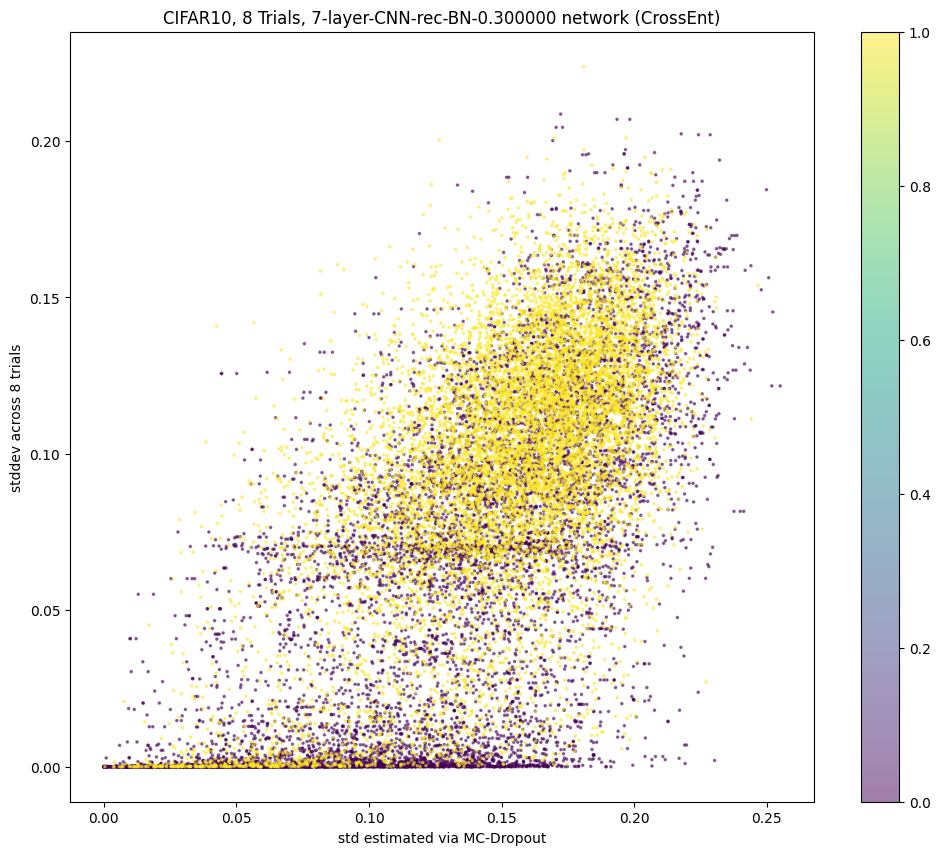

In [29]:
from matplotlib import pyplot as plt
plt.figure(figsize = (12, 10))

colorbar = plt.scatter(
#     nza_std.mean(dim = 1), trial_std.mean(dim = 1), alpha = 0.5, marker = '.',
    dropout_std.mean(dim = 1), trial_std.mean(dim = 1), alpha = 0.5, marker = '.',
    s = 10, c = o_s)
plt.colorbar(colorbar)
plt.xlabel("std estimated via MC-Dropout")
plt.ylabel("stddev across %d trials" % (n_trials))
plt.title("%s, %d Trials, %s network (%s)" % (dataset_name, n_trials, net.model_type, lossType))

plt.savefig("%dtrials_%s(%d)_%s(%s)-%d.png" % (n_trials, dataset_name, n_labeled, net.model_type, lossType, net.hidden_dim))
plt.show()

torch.Size([512, 20000, 10])
tensor([3, 9, 7,  ..., 5, 1, 7])


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:02<00:00, 240.34it/s]


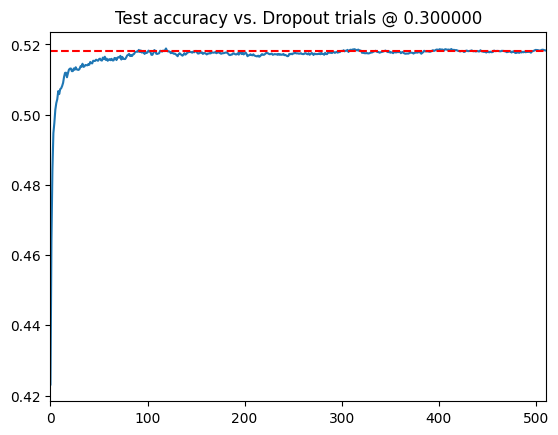

In [30]:
# Test: Dropout mean accuracy

# print(dataset_test.targets)
print(all_logits.shape)

accs = []

GT_acc = (torch.argmax(trial_logits[-1], dim = 1) == y_s).sum() / y_s.shape[0]
print(y_s)

for i in tqdm(range(N_dropout_trials)):
    prediction = torch.argmax(all_logits[:(i+1)].mean(0), dim = 1)
#     print(all_logits[i])
    acc = (prediction == y_s).sum() / y_s.shape[0]
    accs.append(acc)
    
plt.plot(accs)
plt.axhline(y = GT_acc, color = 'r', linestyle = 'dashed')
plt.xlim(0, N_dropout_trials - 1)
plt.title("Test accuracy vs. Dropout trials @ %f" % (net.dropout_rate))

plt.savefig("DropoutMeanAcc_%dtrials_%s(%d)_%s(%s)-%d.png" % (n_trials, dataset_name, n_labeled, net.model_type, lossType, net.hidden_dim))
plt.show()

# TODOs:
# 1. Above cell's figure (estimated vs. GT variance) vs. training epochs
# 2. MC-dropout for larger networks / more complex datasets

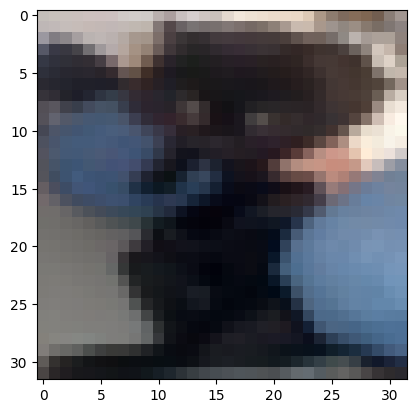

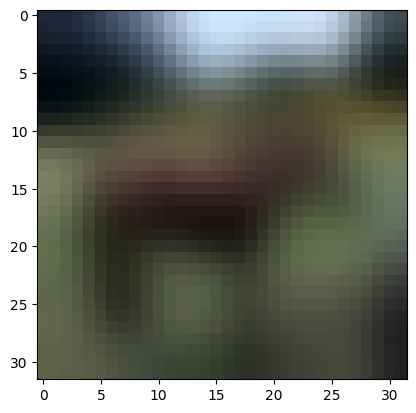

In [31]:
inlier = dataset_test[0]
outlier = dataset_test[-1]

def min_max_normalize(img):
    return (img - img.min()) / (img.max() - img.min())

plt.imshow(min_max_normalize(np.transpose(inlier[0], (1, 2, 0))))
plt.show()
plt.imshow(min_max_normalize(np.transpose(outlier[0], (1, 2, 0))))
plt.show()

In [32]:
# # Modify dropout probability
# def modify_dropout(m, prob):
#     for each_module in m.modules():
#         if each_module.__class__.__name__.startswith('Dropout'):
# #             print("Disabling dropout")
#             each_module.p = prob

# new_p = 0.1
# modify_dropout(net, new_p)
# net.dropout_rate = new_p

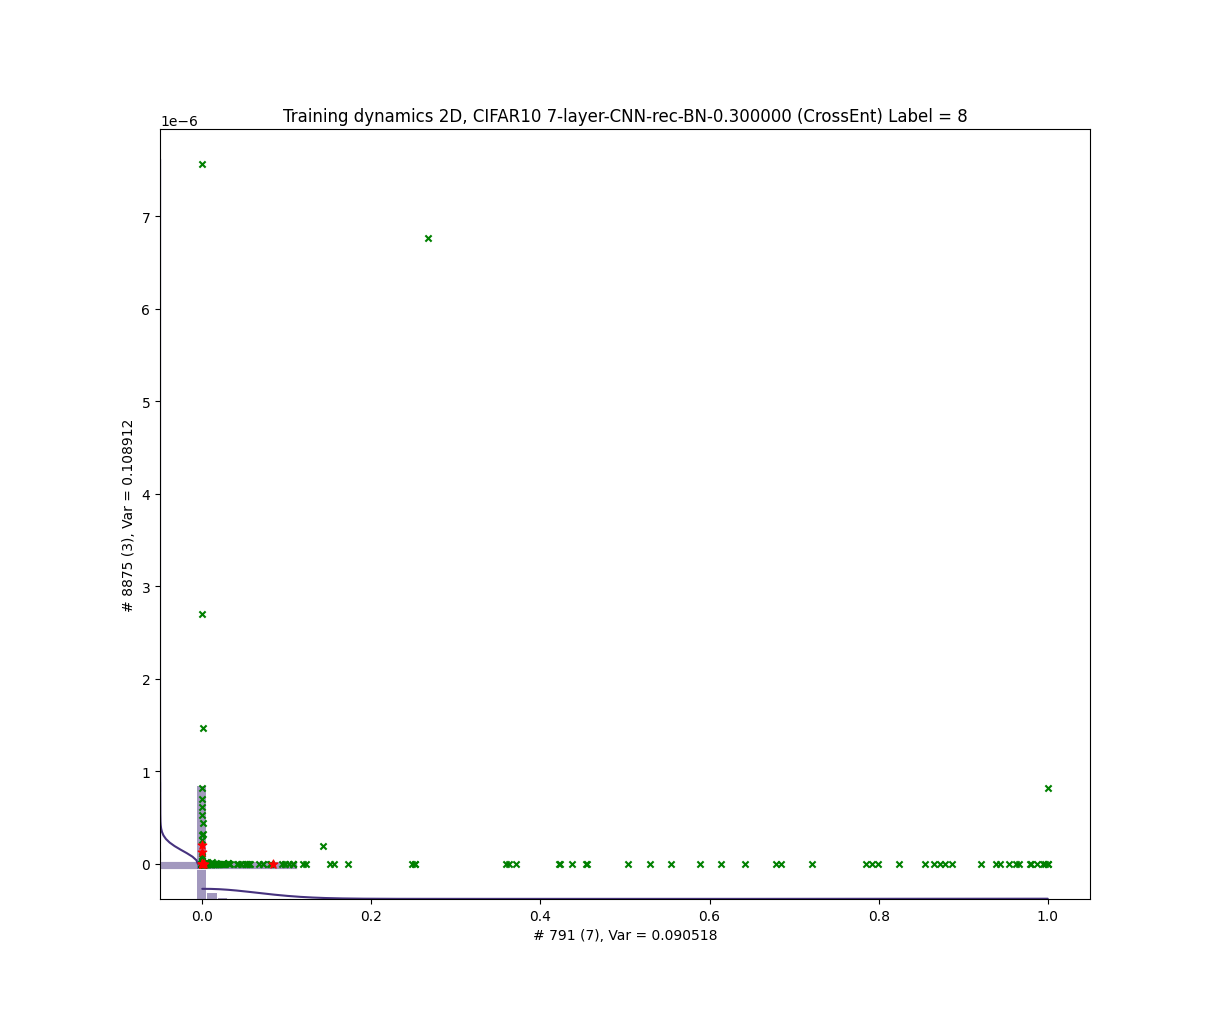

In [49]:
# Draw two-data plot
# Logits from NN parallel trials: trial_logits_t
# Logits from dropout: all_logits
# All having the shape [N_Trials, N_datapoints, N_classes]

# result_trials = trial_logits_t
# result_dropout = all_logits
result_trials = trial_probs
result_dropout = dropout_probs

import seaborn as sns

from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes
import pandas as pd

sns.reset_orig()

labl = 8
pivot_a = 791
pivot_b = 8875
label_a = labl
label_b = labl

minlim_a = min(result_dropout[:, pivot_a, label_a].min().item(), result_trials[:, pivot_a, label_a].min().item())
maxlim_a = max(result_dropout[:, pivot_a, label_a].max().item(), result_trials[:, pivot_a, label_a].max().item())

range_padding_a = 0.05 * (maxlim_a - minlim_a)
minlim_a -= range_padding_a
maxlim_a += range_padding_a

minlim_b = min(result_dropout[:, pivot_b, label_b].min().item(), result_trials[:, pivot_b, label_b].min().item())
maxlim_b = max(result_dropout[:, pivot_b, label_b].max().item(), result_trials[:, pivot_b, label_b].max().item())

range_padding_b = 0.05 * (maxlim_b - minlim_b)
minlim_b -= range_padding_b
maxlim_b += range_padding_b

AB_frame = pd.DataFrame({'a': result_dropout[:,pivot_a,label_a], 'b': result_dropout[:,pivot_b,label_b]})

plt.figure(figsize = (12, 10))

plt.scatter(
    result_dropout[:,pivot_a,label_a].flatten(), result_dropout[:,pivot_b,label_b].flatten(), alpha = 1.0, marker = 'x',
    s = 20, c = 'green')
plt.scatter(
    result_trials[:,pivot_a,label_a].flatten(), result_trials[:,pivot_b,label_b].flatten(), alpha = 1.0, marker = '*',
    s = 40, c = 'red')
plt.xlim(minlim_a, maxlim_a)
plt.ylim(minlim_b, maxlim_b)
plt.xlabel("# %d (%d), Var = %f" % (pivot_a, dataset_test[pivot_a][1], trial_std[pivot_a].mean()))
plt.ylabel("# %d (%d), Var = %f" % (pivot_b, dataset_test[pivot_b][1], trial_std[pivot_b].mean()))

# ax = plt.gca()
# sns.histplot(acts2D[-1, pivot_a, labl, :].flatten(), bins = 20, ax = ax, kde = True)

# plt.scatter(0.47 / 0.50 * minlim, acts2D[-1, pivot_b, labl, :].mean(), color = 'red', marker = 'x')
# plt.scatter(acts2D[-1, pivot_a, labl, :].mean(), 0.47 / 0.50 * minlim, color = 'red', marker = 'x')

plt.title("Training dynamics 2D, %s %s (%s) Label = %d" % (dataset_name, net.model_type, lossType, labl))

ax = plt.gca()
ax.patch.set_alpha(0)

fig = plt.gcf()

sns.set_theme(style="white", palette="viridis")

# Horizontal (pivot A)
#############################################################
ax = fig.add_axes([0.125, 0.11, 0.775, 0.12])
data_acts = result_dropout[:, pivot_a, label_a].flatten()
sns.histplot(data = AB_frame, x = 'a', bins = 80, binrange = (0.9*minlim_a, 0.9*maxlim_a), ax = ax, kde = True)
ax.axis('off')
ax.set_xlim(minlim_a, maxlim_a)
ax.tick_params(color='red', labelcolor='red')
# ax.patch.set_alpha(0)
ax.set_zorder(-10)

# Vertical (pivot B)
#############################################################
# Rotated
ax = fig.add_axes([0.125, 0.11, 0.12, 0.775])
data_acts = result_dropout[:, pivot_b, label_b].flatten()
sns.histplot(data = AB_frame, y = 'b', bins = 80, binrange = (0.9*minlim_b, 0.9*maxlim_b), ax = ax, kde = True)
ax.axis('off')
ax.set_ylim(minlim_b, maxlim_b)
ax.tick_params(color='green', labelcolor='green')
# ax.patch.set_alpha(0)
ax.set_zorder(-10)

ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.set_zorder(-100)

plt.savefig("Two-data plots/[x%d(#%d)-y%d(#%d)-at%d]%dtrials_%s(%d)_%s(%s)-%d.png" % (
    dataset_test[pivot_a][1],
    pivot_a,
    dataset_test[pivot_b][1],
    pivot_b,
    labl,
    n_trials, dataset_name, n_labeled, net.model_type, lossType, net.hidden_dim))
plt.show()

sns.reset_orig()